In [7]:
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import copy
import torch
from craft_text_detector import (
    read_image,
    load_craftnet_model,
    load_refinenet_model,
    get_prediction,
    empty_cuda_cache,
)
from craft_text_detector.file_utils import rectify_poly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
craft_net = load_craftnet_model(cuda = True)
# refine_net = load_refinenet_model(cuda= True)
craft_net.to(device)

def extract_text_box(img):
    img = copy.deepcopy(img)
    prediction_result = get_prediction(
        image=img,
        craft_net=craft_net,
        # refine_net=refine_net,
        text_threshold=0.8,
        link_threshold=0.4,
        low_text=0.3,
        cuda=True,
        long_size=1280
        )
    result_list = []
    for region in prediction_result["boxes"]:
        result_list.append((region,np.array(rectify_poly(img, region))))
    return result_list

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [14]:
path = "test_img.jpg"
img = cv2.imread(path, 1)
result = extract_text_box(img)
coords = result[0][0]
for i in range(1,len(result)):
    coords = np.append(coords, result[i][0], axis= 0)

/home/aiotlab/anaconda3/envs/hiepnm_vaipe/lib/python3.9/site-packages/craft_text_detector/craft_utils.py:415: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  polys = np.array(polys)
/home/aiotlab/anaconda3/envs/hiepnm_vaipe/lib/python3.9/site-packages/craft_text_detector/predict.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  polys_as_ratio = np.array(polys_as_ratio)


In [15]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
hull = ConvexHull(coords) 

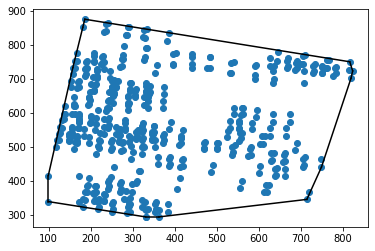

In [16]:
import matplotlib.pyplot as plt
plt.plot(coords[:,0], coords[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(coords[simplex, 0], coords[simplex, 1], 'k-')

In [17]:
from minimumboundingbox.MinimumBoundingBox import MinimumBoundingBox

points = tuple()
for idx in hull.vertices:
    points += ((coords[idx, 0], coords[idx, 1]),)
points = tuple(points)
print(points)
bounding_box = MinimumBoundingBox(points)  # returns namedtuple

print(bounding_box.area)
print(bounding_box.rectangle_center)
print(list(bounding_box.corner_points))

((99.0, 416.25), (99.0, 339.75), (330.75, 294.75), (362.25, 294.75), (714.54816, 346.24042), (749.25, 441.0), (819.63, 702.08997), (823.554, 723.6719), (816.6402, 750.5122), (185.8846, 875.4231), (181.12498, 851.62506), (157.5, 733.5))
355572.32901689294
(454.5018627247273, 545.7882277164745)
[(185.61609049233772, 875.4762692031255), (723.3876349571169, 216.1001862298233), (828.744542212152, 748.1151415425518), (80.25918323730258, 343.46131389039726)]


In [18]:
rect = list(bounding_box.corner_points)
rect = list(map(lambda x: list(x), rect))
rect = np.array(rect)

In [19]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

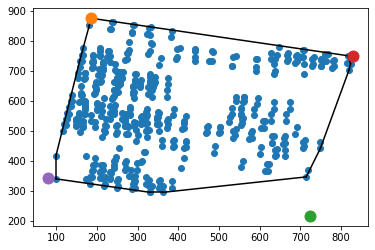

In [20]:
import matplotlib.pyplot as plt
plt.plot(coords[:,0], coords[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(coords[simplex, 0], coords[simplex, 1], 'k-')
for i in range(len(rect)):
    plt.plot(rect[i][0], rect[i][1], 'o', markersize= 11)

In [22]:
def four_point_transform(image, pts):
    rect = order_points(pts)
    tl, tr, br, bl = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped, M

In [23]:
warped, M = four_point_transform(img, rect)

In [24]:
import imutils

In [25]:
warped

array([[[155, 155, 143],
        [155, 155, 143],
        [155, 155, 143],
        ...,
        [160, 161, 152],
        [160, 161, 152],
        [160, 161, 152]],

       [[155, 155, 143],
        [155, 155, 143],
        [155, 155, 143],
        ...,
        [160, 161, 152],
        [160, 161, 152],
        [160, 161, 152]],

       [[155, 155, 143],
        [155, 155, 143],
        [155, 155, 143],
        ...,
        [160, 161, 152],
        [160, 161, 152],
        [160, 161, 152]],

       ...,

       [[154, 156, 150],
        [154, 156, 150],
        [154, 156, 150],
        ...,
        [167, 169, 163],
        [167, 169, 163],
        [167, 169, 163]],

       [[154, 156, 150],
        [154, 156, 150],
        [154, 156, 150],
        ...,
        [167, 169, 163],
        [167, 169, 163],
        [167, 169, 163]],

       [[154, 156, 150],
        [154, 156, 150],
        [154, 156, 150],
        ...,
        [167, 169, 163],
        [167, 169, 163],
        [167, 169, 163]]

In [27]:
plt.imsave("result.jpg", warped)